<a href="https://colab.research.google.com/github/Ziadnasser1/Machine-Learning-Training/blob/master/DecisionTrreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [80]:
tennisData = pd.read_csv('/content/PlayTennis.csv')

dummies_dict = {'Yes': 1, 'No': 0}
tennisData['Play Tennis'] = tennisData['Play Tennis'].map(dummies_dict)


tennisData.head(14)

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,0
1,Sunny,Hot,High,Strong,0
2,Overcast,Hot,High,Weak,1
3,Rain,Mild,High,Weak,1
4,Rain,Cool,Normal,Weak,1
5,Rain,Cool,Normal,Strong,0
6,Overcast,Cool,Normal,Strong,1
7,Sunny,Mild,High,Weak,0
8,Sunny,Cool,Normal,Weak,1
9,Rain,Mild,Normal,Weak,1


In [94]:
class Node:
    def __init__(self, feature=None, value=None, prediction=None):
        self.feature = feature
        self.value = value
        self.prediction = prediction
        self.children = {}

    def add_child(self, value, node):
        self.children[value] = node

    def __repr__(self):
        if self.prediction is not None:
            return f"Leaf Node: Prediction={self.prediction}"
        else:
            return f"Internal Node: Feature={self.feature}, Value={self.value}"

class DecisionTree:

    def entropy(self, labels):
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        probabilities = label_counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def average_entropy(self, data, feature_name):
        unique_values = data[feature_name].unique()#features names.
        avg_entropy = 0
        total_instances = len(data)
        for value in unique_values:
            subset = data[data[feature_name] == value]
            subset_entropy = self.entropy(subset['Play Tennis'])
            subset_weight = len(subset) / total_instances
            avg_entropy += subset_weight * subset_entropy
        return avg_entropy

    def information_gain(self, data, feature_name):
        total_entropy = self.entropy(data['Play Tennis'])
        avg_entropy = self.average_entropy(data, feature_name)
        return total_entropy - avg_entropy

    def build_tree(self, data, features):
        if len(data['Play Tennis'].unique()) == 1:
            return Node(prediction=data['Play Tennis'].iloc[0])

        if len(features) == 0:
            return Node(prediction=data['Play Tennis'].mode()[0])

        best_feature = None
        best_gain = -1
        for feature in features:
            gain = self.information_gain(data, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        root = Node(feature=best_feature)
        remaining_features = [f for f in features if f != best_feature]
        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]
            child_node = self.build_tree(subset, remaining_features)
            root.add_child(value, child_node)

        return root

    def predict(self, node, sample):
        if node.prediction is not None:
            return node.prediction
        value = sample[node.feature]
        if value in node.children:
            return self.predict(node.children[value], sample)
        else:
            return None


X = tennisData.drop('Play Tennis', axis=1)
y = tennisData['Play Tennis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

features = X_train.columns


dt = DecisionTree()
root_node = dt.build_tree(pd.concat([X_train, y_train], axis=1), features)


predictions = []
for _, sample in X_test.iterrows():
    prediction = dt.predict(root_node, sample)
    predictions.append(prediction)


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


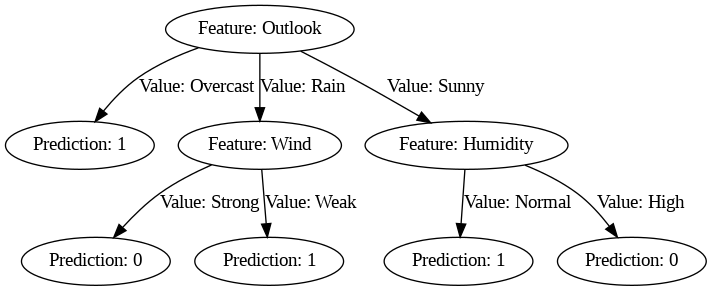

In [92]:
import graphviz
from IPython.display import Image

def plot_tree(node, dot=None):
    if dot is None:
        dot = graphviz.Digraph()

    if node.prediction is not None:
        dot.node(str(id(node)), label=f"Prediction: {node.prediction}", shape='oval')
    else:
        dot.node(str(id(node)), label=f"Feature: {node.feature}")
        for value, child_node in node.children.items():
            child_id = plot_tree(child_node, dot)
            dot.edge(str(id(node)), str(child_id), label=f"Value: {value}")

    return id(node)


dot = graphviz.Digraph()
plot_tree(root_node, dot)
dot.render('decision_tree', format='png', cleanup=True)

Image(filename='/content/decision_tree.png')